In [1]:
import gjp
import statistics
import numpy as np
import pandas as pd
import iqisa as iqs

In [2]:
market_fcasts=gjp.load_markets()
survey_fcasts=gjp.load_surveys()
gjp_questions=gjp.load_questions()

/home/niplav/proj/iqisa/gjp.py:326: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  forecasts=load_complete_markets(files)
/usr/lib/python3/dist-packages/dateutil/parser/_parser.py:1199: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/usr/lib/python3/dist-packages/dateutil/parser/_parser.py:1199: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/home/niplav/proj/iqisa/gjp.py:326: DtypeWarning: Columns (6,7,9,21) have mixed types.Specify dtype option on import or set low_memory=False.
  forecasts=load_compl

In [3]:
print(market_fcasts.shape)
print(survey_fcasts.shape)
print(gjp_questions.shape)

(793501, 15)
(3143460, 15)
(617, 14)


In [4]:
def brier_score(probabilities, outcomes, *args):
        return np.mean((probabilities-outcomes)**2)

trader_scores=iqs.score(market_fcasts, brier_score, on=['user_id'])
filtered_trader_scores=iqs.score(market_fcasts.groupby(['user_id']).filter(lambda x: len(x)>100), brier_score, on=['user_id'])
highly_filtered_trader_scores=iqs.score(market_fcasts.groupby(['user_id']).filter(lambda x: len(x)>1000), brier_score, on=['user_id'])

In [5]:
print(trader_scores.describe())
print(filtered_trader_scores.describe())
print(highly_filtered_trader_scores.describe())

             score
count  2408.000000
mean      0.159125
std       0.079836
min       0.000100
25%       0.117289
50%       0.151209
75%       0.186772
max       0.792100
            score
count  967.000000
mean     0.159525
std      0.052282
min      0.024330
25%      0.129488
50%      0.155539
75%      0.181879
max      0.685084
            score
count  138.000000
mean     0.151327
std      0.037286
min      0.044546
25%      0.129421
50%      0.150234
75%      0.175377
max      0.248004


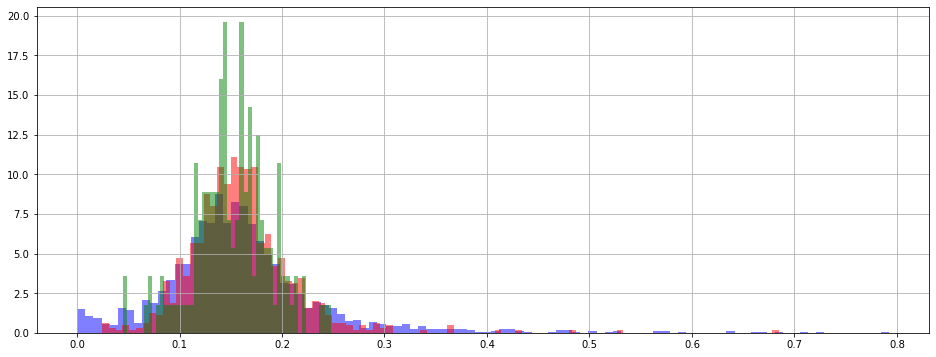

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,6))
plt.hist(trader_scores['score'], bins=100, density=True, alpha=0.5, align='mid', color='blue')
plt.hist(filtered_trader_scores['score'], bins=100, density=True, alpha=0.5, align='mid', color='red')
plt.hist(highly_filtered_trader_scores['score'], bins=50, density=True, alpha=0.5, align='mid', color='green')
plt.grid()

### Different Analyses

When wanting to know how well groups of forecasters perform, we can perform different kinds of analyses, with different kinds of aggregated parts of the dataset.

1. We score forecasters, and sort them by their score.
2. We randomly choose groups of forecasters of size $2 \le i \le n$ (for some maximal $n$) and then compute the score of those groups. On average, what percentile of forecaster performance does a group of size $i$ find itself in?
    1. We also aggregate the forecasts from those groups in a smarter way.
3. We score teams of forecasters and find out what percentile of forecaster performance each team finds themselves in.
    1. We also aggregate the forecasts from those teams in a smarter way.

In [7]:
max_group_size=100
sample_size=100
groups=[np.random.choice(np.unique(market_fcasts['user_id']), size=(sample_size, i)) for i in range(2, max_group_size)]

In [8]:
def geom_odds_aggr(forecasts):
    probabilities=forecasts['probability']
    probabilities=probabilities/(1-probabilities)
    aggregated=statistics.geometric_mean(probabilities)
    aggregated=aggregated/(1+aggregated)
    return np.array([aggregated])

In [ ]:
all_group_scores=pd.DataFrame(columns=['size', 'score', 'aggregated'])
for i in range(0, max_group_size-2):
    for group in groups[i]:
        group_table=pd.DataFrame({'user_id': group})
        group_forecasts=pd.merge(market_fcasts, group_table, on=['user_id'], how='inner')
        aggregated_group_forecasts=iqs.aggregate(group_forecasts, geom_odds_aggr)
        group_scores=iqs.score(group_forecasts, brier_score)['score']
        aggregated_group_scores=iqs.score_aggregations(aggregated_group_forecasts, brier_score)['score']
        group_score=np.mean(group_scores)
        aggregated_group_score=np.mean(aggregated_group_scores)
        nf=pd.DataFrame({'size': [i+2, i+2], 'score': [group_score, aggregated_group_score], 'aggregated': [False, True]})
        all_group_scores=pd.concat([all_group_scores, nf])

In [ ]:
group_scores=all_group_scores.groupby(['size', 'aggregated']).apply(lambda x: np.mean(x['score']))
group_scores=group_scores.reset_index(name='score')
group_scores['percentile']=group_scores['score'].apply(lambda x: len(np.where(trader_scores['score']>x)[0])/len(trader_scores))
group_scores

In [ ]:
notaggregated=group_scores.loc[group_scores['aggregated']==False].set_index(['size'])
aggregated=group_scores.loc[group_scores['aggregated']==True].set_index(['size'])
fig=plt.figure(figsize=(16,6))
plt.xlabel('Forecaster group size')
plt.ylabel('Group score percentile')
plt.plot(notaggregated['percentile'], color='blue', label='not aggregated percentile')
plt.plot(aggregated['percentile'], color='red', label='aggregated percentile')

plt.legend(loc='lower left')